### Importação da base

In [54]:
import pandas as pd


df_root = pd.read_excel('df_clusterizado.xlsx')




df_root['valor'] = df_root.apply(
    lambda row: -row['valor'] if row['Tipo'] == 'credito' else row['valor'], axis=1
)


In [55]:
df_root[df_root['Tipo'] == 'credito'].head()


,data,lançamento,valor,Tipo,Cluster,sub-cluster
0,2021-12-30,English Live,-263.00,credito,assinaturas e parcelamentos,não se aplica
1,2024-01-03,Amazon Digital,-14.90,credito,assinaturas e parcelamentos,não se aplica
2,2024-01-03,Google Telegram,-19.90,credito,assinaturas e parcelamentos,não se aplica
3,2024-01-04,99* POP 04Jan,-25.20,credito,uber,não se aplica
4,2024-01-04,Amazon Digital,-41.58,credito,assinaturas e parcelamentos,não se aplica


### Separação das entradas em teste e treinamento de forma extratificada

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit

# Verifique se os clusters têm valores representativos antes da estratificação
cluster_value_counts = df_root['Cluster'].value_counts()
print(cluster_value_counts)

# Criação da coluna 'strat_column' que combina 'Cluster' e 'sub-cluster' para estratificação
df_root['strat_column'] = df_root['Cluster'] + "_" + df_root['sub-cluster']

# Inicialização do StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df_root, df_root['strat_column']):
    strat_train_set = df_root.loc[train_index]
    strat_test_set = df_root.loc[test_index]

Cluster
gastos gerais debito           532
uber                           461
assinaturas e parcelamentos    438
pix                            296
delivery                       290
despezas                       238
aplicaut                       175
pagamentos                     153
taxas                           75
rendimentos                     73
drogaria                        69
fatura cartao                   38
saldo                           17
viagem                           7
Name: count, dtype: int64


In [57]:

def validate_stratification(original_df, stratified_df, strat_column):
    # Calcula a proporção de cada classe na base original
    original_proportions = original_df[strat_column].value_counts(normalize=True)
    
    # Calcula a proporção de cada classe na base estratificada
    stratified_proportions = stratified_df[strat_column].value_counts(normalize=True)
    
    # Cria um DataFrame para comparar as proporções
    comparison_df = pd.DataFrame({
        'Original Proportion': original_proportions,
        'Stratified Proportion': stratified_proportions
    })
    
    # Calcula a diferença entre as proporções
    comparison_df['Difference'] = comparison_df['Stratified Proportion'] - comparison_df['Original Proportion']
    
    # Exibe o resultado
    print("Comparison of Class Proportions between Original and Stratified DataFrames:")
    print(comparison_df)
    
    # Verifica se as diferenças são pequenas o suficiente
    if comparison_df['Difference'].abs().max() < 0.01:  # Tolerância de 1%
        print("\nEstratificação validada: as proporções das classes são consistentes.")
    else:
        print("\nAtenção: Há diferenças significativas nas proporções das classes.")

In [58]:
strat_counts = df_root['strat_column'].value_counts()
print(strat_counts[strat_counts < 2])

Series([], Name: count, dtype: int64)


In [59]:
df_root.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   data          2862 non-null   datetime64[ns]
 1   lançamento    2862 non-null   object        
 2   valor         2862 non-null   float64       
 3   Tipo          2862 non-null   object        
 4   Cluster       2862 non-null   object        
 5   sub-cluster   2862 non-null   object        
 6   strat_column  2862 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 156.6+ KB


In [38]:
validate_stratification(df_root, strat_train_set, 'strat_column')


Comparison of Class Proportions between Original and Stratified DataFrames:
                                           Original Proportion  \
strat_column                                                     
uber_não se aplica                                    0.161076   
assinaturas e parcelamentos_não se aplica             0.153040   
gastos gerais debito_pontual                          0.108316   
pix_não se aplica                                     0.103424   
delivery_não se aplica                                0.101328   
aplicaut_não se aplica                                0.061146   
pagamentos_não se aplica                              0.053459   
gastos gerais debito_alimentacao                      0.036338   
despezas_pontual                                      0.029350   
taxas_não se aplica                                   0.026205   
rendimentos_não se aplica                             0.025507   
drogaria_não se aplica                                0.024109   


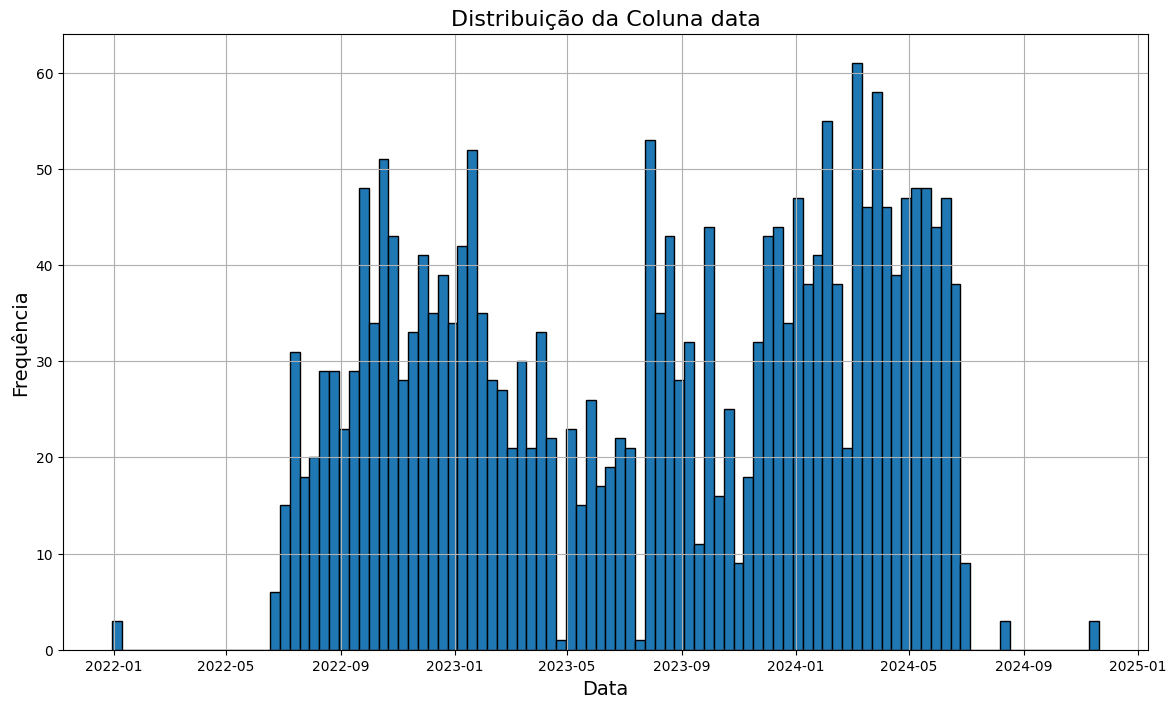

In [62]:
import matplotlib.pyplot as plt

# Definir o tamanho da plotagem
plt.figure(figsize=(14, 8))  # Aumenta o tamanho da figura

# Plotar o histograma com barras mais finas
strat_train_set['data'].hist(bins=100, edgecolor='black')  # bins define o número de barras; quanto maior, mais finas as barras

# Adicionar títulos e rótulos para melhor visualização
plt.title('Distribuição da Coluna data', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Mostrar a plotagem
plt.show()

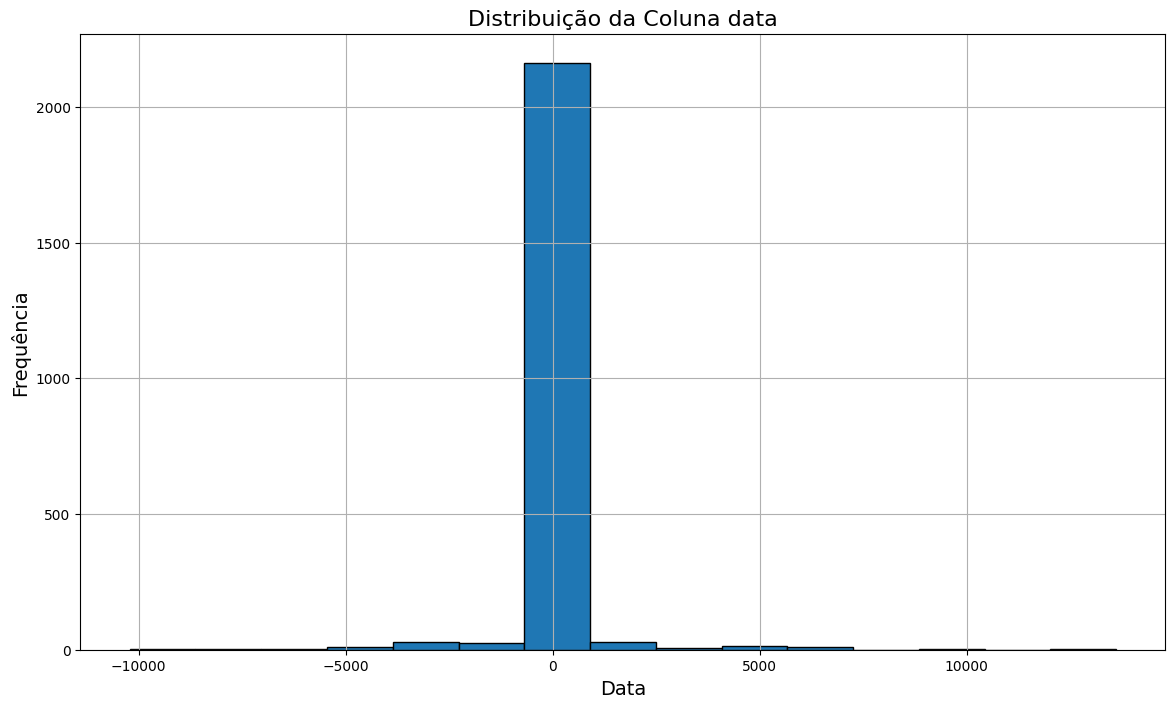

In [66]:
import matplotlib.pyplot as plt

# Definir o tamanho da plotagem
plt.figure(figsize=(14, 8))  # Aumenta o tamanho da figura

# Plotar o histograma com barras mais finas
strat_train_set['valor'].hist(bins=15, edgecolor='black')  # bins define o número de barras; quanto maior, mais finas as barras

# Adicionar títulos e rótulos para melhor visualização
plt.title('Distribuição da Coluna data', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Mostrar a plotagem
plt.show()

In [86]:
strat_train_set.groupby('Cluster')['valor'].apply(lambda x: x.abs().sum()).sort_values(ascending=False)


Cluster
rendimentos                    205941.32
fatura cartao                  111535.43
aplicaut                        77684.77
pix                             75364.46
assinaturas e parcelamentos     26121.86
gastos gerais debito            20703.49
pagamentos                      20032.56
despezas                        18831.44
delivery                        14627.24
uber                             8993.04
drogaria                         5535.14
saldo                            5022.22
taxas                            3453.82
viagem                           2802.00
Name: valor, dtype: float64

In [87]:
strat_train_set.describe()

,data,valor
count,2289,2289.000000
mean,2023-07-26 01:05:25.557011968,-24.312988
min,2021-12-30 00:00:00,-10212.890000
25%,2022-12-30 00:00:00,-85.120000
50%,2023-08-16 00:00:00,-35.000000
75%,2024-02-14 00:00:00,-13.000000
max,2024-11-20 00:00:00,13602.820000
std,NaN,1002.224479


<Axes: xlabel='data', ylabel='valor'>

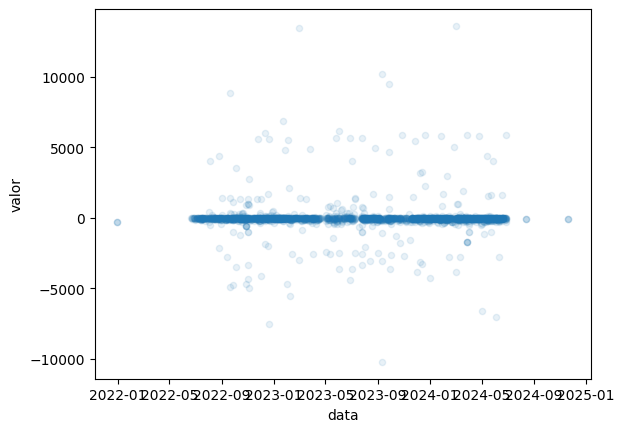

In [89]:
strat_train_set.plot(kind='scatter', x='data', y='valor', alpha=0.1)

In [91]:
df = strat_train_set[['data','valor']].copy()
corr_matrix = df.corr()

In [92]:
corr_matrix

,data,valor
data,1.000000,0.001491
valor,0.001491,1.000000
